In [5]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakeManila, FakeToronto, FakeJakartaV2, FakeProvider
from qiskit.circuit import Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import QDrift, LieTrotter, SuzukiTrotter
from qiskit import execute

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing as skp
from scipy.signal import savgol_filter
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..')) # qrc_surrogate
sys.path.append(module_path)
fig_path = f'{module_path}/figs'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC,  QRewindingRC_Neat
from src.data import DataSource

from iqm.qiskit_iqm import IQMFakeAdonis
from iqm.qiskit_iqm import IQMProvider,transpile_to_IQM,optimize_single_qubit_gates

server_url = "https://cocos.resonance.meetiqm.com/garnet"  # For example https://cocos.resonance.meetiqm.com/garnet
api_token = "287K1FQqLZ9JU+FxO6C4l6TXENKy0SFUO8h5P4po3DIGZeGb5qhzo4AAi21PIAqd"

SHOTS = 8000

IQMbackend = IQMProvider(server_url, token=api_token).get_backend()
sim_Backend=AerSimulator()
from qiskit.quantum_info.operators.symplectic import Pauli
from itertools import product,permutations

In [424]:
def Simulated_Reservoir(nsteps_in,enc):
    
    Meas_List=[] # we need to keep this for set-up of the final circuits.

    # We produce a custom version of the "manual constuction".
    Manual_Layout_List=[]
    nmem = 3
    nsteps=nsteps_in
    for step in range(nsteps):
        memory_qubits=list(range(nmem))
        data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
        Manual_Layout_List+= [memory_qubits + data_qubits]
    print(Manual_Layout_List)
    if max(Manual_Layout_List[-1])>nmem+2*nsteps:
        print('warning: circuit too large for backend!')
        qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
    else:
    #Overall circuit!
        qc = QuantumCircuit(nmem+2*nsteps, nmem+2*nsteps)

    #And the current circuit.
    c_circuit = QuantumCircuit(5,2)



        

    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    #gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

    #For the automatic circuits, we use the qiskit gates and allow transpilation.

        

    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 /1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc:
                        case 'x':
                            qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={self.encaxes}')
                elif False: 
                    self.encaxes = ['ry', 'rz']
                    qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    
                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        for i in range(len(c_qubits)-1):
            qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
        qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

        #XROT
        for i in range(len(c_qubits)):
            #X
            
            qc.rx(theta=theta_list[i],qubit=c_qubits[i])
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            




        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List[-1]=Manual_Layout_List[-1]

    #We now have to transpile the circuit!
    ## define the circuit to be run on the hardware
    #opt_level = self.opt_level ## defines the optimization level


    #Not necessary...

    #if (self.QPU == 'Apollo'):
    #    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
    #elif (self.QPU == 'Adonis'):
    #    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

    # We allow qiskit to perform transpilation!
    #tqc = transpile(qc,backend=self.backend,optimization_level=opt_level)
    # We need to see how the qubits have been permuted:
    #perm_lib_qiskit=tqc.layout.initial_layout
    # This is the wrong form for our purposes: we need to swap it:

    #meas_mapping={perm_lib_qiskit[k].index:k for k in range(self.backend.num_qubits)}

    #self.all_meas=[[meas_mapping[i] for i in k] for k in self.all_meas]

    return qc, Meas_List




In [10]:
[qc3,Meas3] = Simulated_Reservoir(3,'x')

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6], [0, 1, 2, 7, 8]]


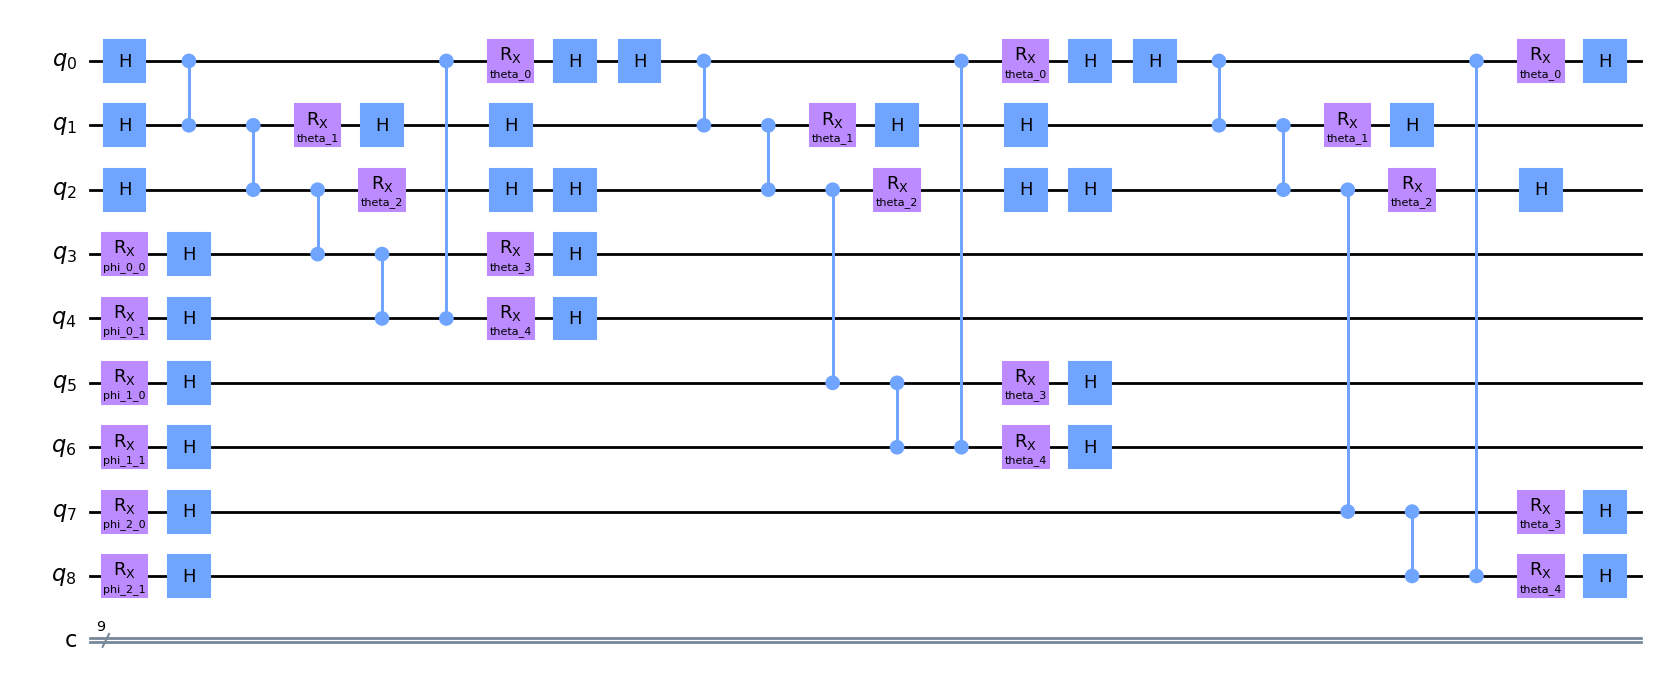

In [11]:
qc3.draw('mpl')

In [425]:
def Evaluate_Features(qc,nmem,nin,nsteps,phi,theta):
    param_map={k.name:k for k in qc.parameters}
    shape_phi=phi.shape
    phi_assignment={param_map['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
    theta_assignment={param_map['theta_%s' % k]:theta[k] for k in range(len(theta))}
    explicit_val=qc.assign_parameters(phi_assignment)
    explicit_val=explicit_val.assign_parameters(theta_assignment)
    explicit_val.save_statevector()
    backend = AerSimulator(method='statevector')
    job = backend.run(explicit_val, shots=1, memory=True)
    job_result = job.result()
    sv=job_result.get_statevector(explicit_val)

    #Need expectation values!
    nqubits=len(qc.qubits)
    XL = []
    YL = []
    ZL = []
    partialX=list(''.join(k) for k in product('IX',repeat=nin))
    partialY=list(''.join(k) for k in product('IY',repeat=nin))
    partialZ=list(''.join(k) for k in product('IZ',repeat=nin))
    for i in range(nsteps-1):
        XL += [('I'*nmem)+('I'*(nin*i))+(k)+('I'*(nin*(nsteps-1-i))) for k in partialX ]
        YL += [('I'*nmem)+('I'*(nin*i))+(k)+('I'*(nin*(nsteps-1-i))) for k  in partialY ]
        ZL += [('I'*nmem)+('I'*(nin*i))+(k)+('I'*(nin*(nsteps-1-i))) for k  in partialZ ]
    
    
    #Now add manually the final measurements:
    fbody=3
    original_meas_x=['I'*(nmem+nin-fcurr)+'X'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_y=['I'*(nmem+nin-fcurr)+'Y'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_z=['I'*(nmem+nin-fcurr)+'Z'*fcurr for fcurr in range(1,fbody+1)]
    for fcurr in range(fbody):
        xstrings=list(set(list(''.join(k) for k in permutations(original_meas_x[fcurr], nmem+nin))))
        xfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in xstrings]
        XL += xfinal
        ystrings=list(set(list(''.join(k) for k in permutations(original_meas_y[fcurr], nmem+nin))))
        yfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in ystrings]
        YL += yfinal
        zstrings=list(set(list(''.join(k) for k in permutations(original_meas_z[fcurr], nmem+nin))))
        zfinal=[k[0:nmem]+'I'*(nin*(nsteps-1))+k[nmem:] for k in zstrings]
        ZL += zfinal
    #print(ZL)
    #use [::-1] as Qiskit opposite of what I think!
    X = [sv.expectation_value(Pauli(k[::-1])) for k in XL]
    Y = [sv.expectation_value(Pauli(k[::-1])) for k in YL]
    Z = [sv.expectation_value(Pauli(k[::-1])) for k in ZL]
    
   
    return X,Y,Z,explicit_val,sv




In [109]:
[X0,Y0,Z0,ev,sv]=Evaluate_Features(qc3,3,2,3,np.zeros([3,2]),np.zeros([5]))

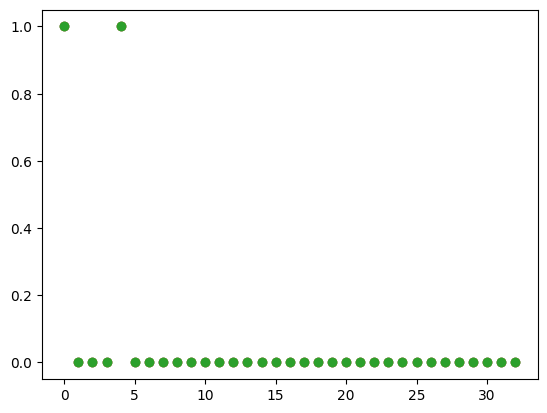

In [426]:
X0,Y0,Z0,ev,sv =Evaluate_Features(qc3,3,2,3,np.zeros([3,2]),np.zeros([5]))
plt.scatter(range(len(X0)),X0)
plt.scatter(range(len(X0)),Y0)
plt.scatter(range(len(X0)),Z0)

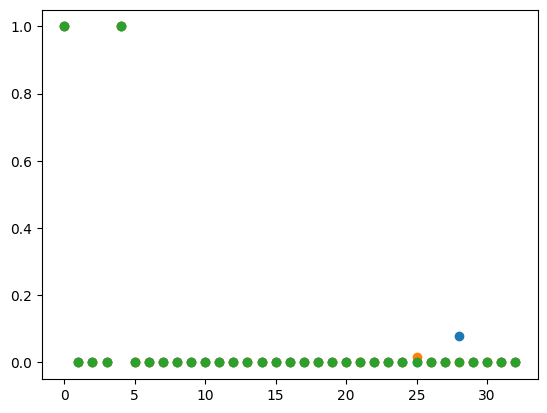

In [427]:
phi2=np.array([[np.pi*0.8,0],[np.pi*0.8,0],[np.pi*0.8,0]])
theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
X0,Y0,Z0,a,b =Evaluate_Features(qc3,3,2,3,phi2,theta2)
plt.scatter(range(len(X0)),X0)
plt.scatter(range(len(X0)),Y0)
plt.scatter(range(len(X0)),Z0)

In [428]:
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,a,b =Evaluate_Features(qc3,3,2,3,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

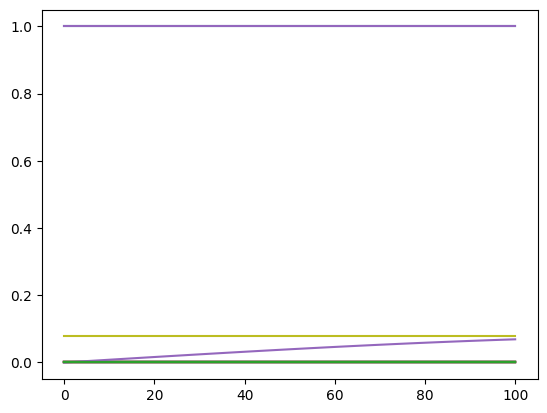

In [429]:
plt.plot(XEV)

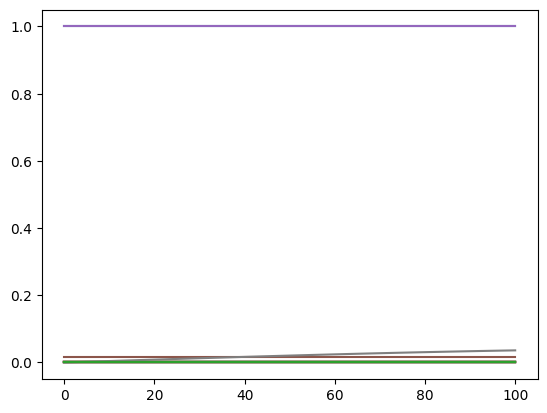

In [430]:
plt.plot(YEV)

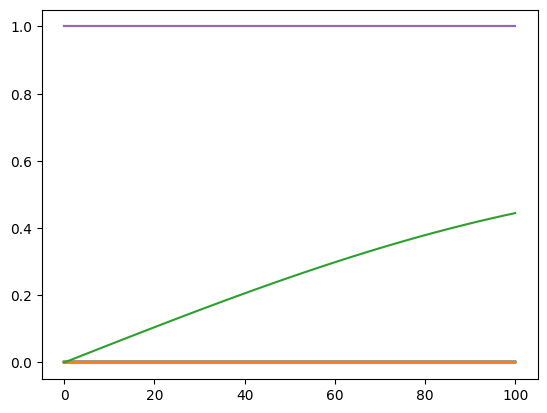

In [431]:
plt.plot(ZEV)

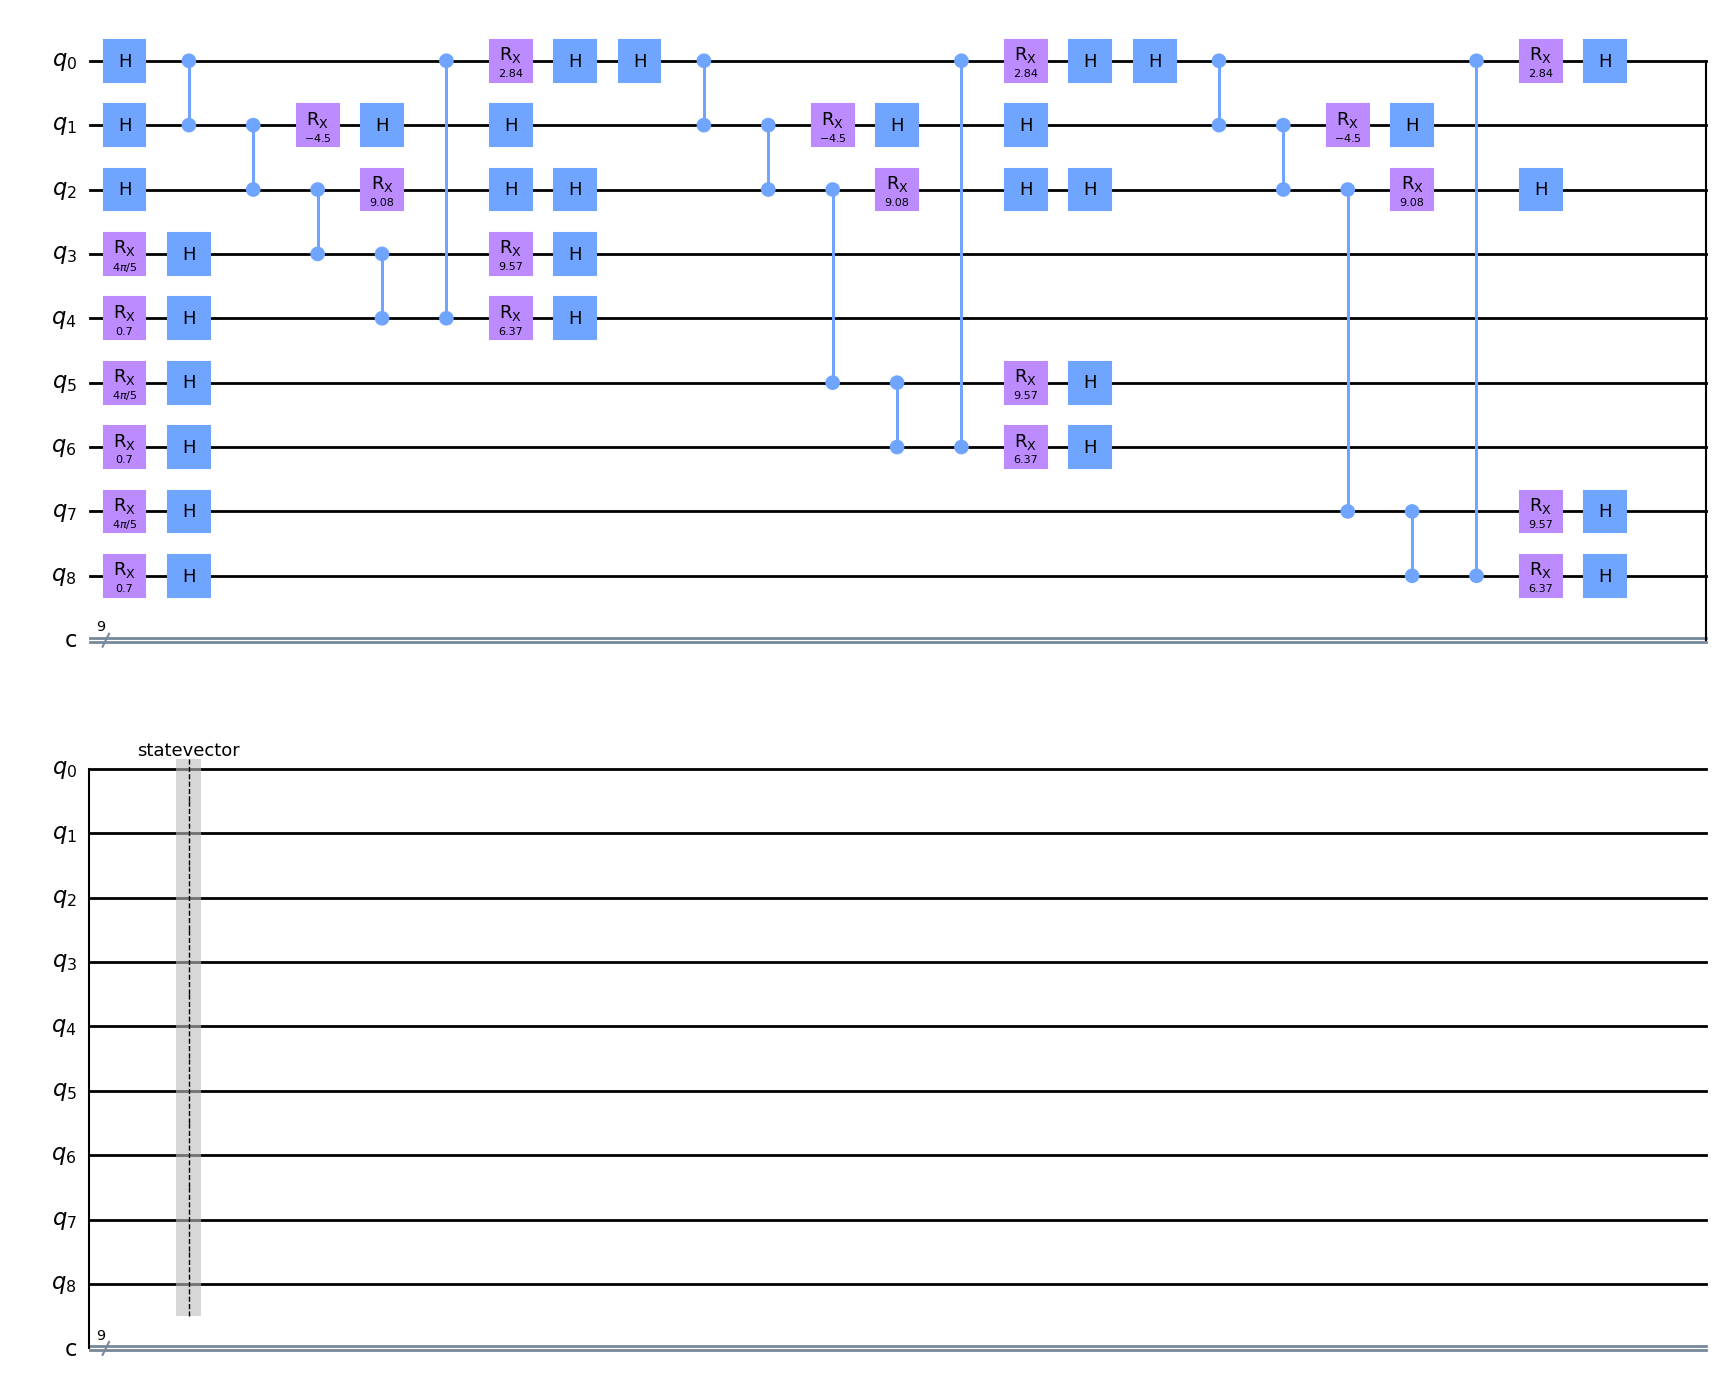

In [231]:
ev.draw('mpl')

In [16]:
def Simulated_Transpiled_Reservoir(nsteps_in,enc):
    
    Meas_List=[] # we need to keep this for set-up of the final circuits.

    # We produce a custom version of the "manual constuction".
    Manual_Layout_List=[]
    nmem = 3
    nsteps=nsteps_in
    for step in range(nsteps):
        memory_qubits=list(range(nmem))
        data_qubits=list(range(nmem+step*2,nmem+(step+1)*2))
        Manual_Layout_List+= [memory_qubits + data_qubits]
    print(Manual_Layout_List)
    if max(Manual_Layout_List[-1])>nmem+2*nsteps:
        print('warning: circuit too large for backend!')
        qc = QuantumCircuit(Manual_Layout_List[-1],Manual_Layout_List[-1])
    else:
    #Overall circuit!
        qc = QuantumCircuit(20, nmem+2*nsteps)

    #And the current circuit.
    c_circuit = QuantumCircuit(5,2)



        

    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    #gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)

    #For the automatic circuits, we use the qiskit gates and allow transpilation.

        

    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 /1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc:
                        case 'x':
                            qc.rx(theta=phi_c,qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.ry(theta=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.rz(phi=phi_c, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={self.encaxes}')
                elif False: 
                    self.encaxes = ['ry', 'rz']
                    qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    
                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        for i in range(len(c_qubits)-1):
            qc.cz(control_qubit=c_qubits[i],target_qubit=c_qubits[i+1])
        qc.cz(control_qubit=c_qubits[-1],target_qubit=c_qubits[0])

        #XROT
        for i in range(len(c_qubits)):
            #X
            
            qc.rx(theta=theta_list[i],qubit=c_qubits[i])
            #H
            qc.h(qubit=c_qubits[i])
            #qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            




        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List[-1]=Manual_Layout_List[-1]

    #We now have to transpile the circuit!
    ## define the circuit to be run on the hardware
    #opt_level = self.opt_level ## defines the optimization level


    #Not necessary...

    #if (self.QPU == 'Apollo'):
    #    qubit_names = ["QB3", "QB8", "QB4", "QB9", "QB13", "QB14", "QB5", "QB10", "QB15", "QB6", "QB11", "QB16", "QB7", "QB12", "QB17", "QB18", "QB19", "QB20", "QB1", "QB2"]
    #elif (self.QPU == 'Adonis'):
    #    qubit_names = ["QB1", "QB3", "QB2", "QB4", "QB5"]

    # We allow qiskit to perform transpilation!
    tqc = transpile(qc,backend=IQMbackend,optimization_level=3)
    # We need to see how the qubits have been permuted:
    init_perm_lib_qiskit=tqc.layout.initial_layout
    final_perm_lib_qiskit=tqc.layout.final_layout
    # This is the wrong form for our purposes: we need to swap it:
    end_mapping={final_perm_lib_qiskit[k].index:k for k in range(20)}
    begin_mapping={init_perm_lib_qiskit[k].index:k for k in range(20)}

    Meas_List=[[end_mapping[begin_mapping[i]] for i in k] for k in Meas_List]

    #perm_lib_qiskit=tqc.layout.initial_layout
    # This is the wrong form for our purposes: we need to swap it:

    
    #meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}

    #Meas_List=[[meas_mapping[i] for i in k] for k in Meas_List]

    return tqc, Meas_List


In [259]:
[tqc1,tMeas1] = Simulated_Transpiled_Reservoir(1,'y')


[[0, 1, 2, 3, 4]]


/tmp/ipykernel_1640017/16163771.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  meas_mapping={perm_lib_qiskit[k].index:k for k in range(20)}


In [262]:
tMeas1

[[5, 10, 11, 16, 6]]

In [433]:
[tqc1,tMeas1] = Simulated_Transpiled_Reservoir(1,'y')
phi2=np.array([[np.pi*0.8,0]])
theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(tqc1,tMeas1,3,2,1,phi2,theta2)

[[0, 1, 2, 3, 4]]


/tmp/ipykernel_1640017/1737036323.py:126: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  end_mapping={final_perm_lib_qiskit[k].index:k for k in range(20)}
/tmp/ipykernel_1640017/1737036323.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  begin_mapping={init_perm_lib_qiskit[k].index:k for k in range(20)}


 We create a string function which inserts the desired Pauli string into a string of identities. We use the stadard (i.e. non-qiskit) ordering: this is reversed within the function.

In [26]:
def replacer(s, newstring, indices, nofail=False):
    # raise an error if index is outside of the string


    for i in range(len(indices)):
        s = s[:indices[i]] + newstring[i] + s[indices[i] + 1:]

    # insert the new string between "slices" of the original
    return s

In [435]:
test_operator=replacer('I'*20,'XYZ',[6,7,19]) #count is from 0.
print(test_operator[6])
print(test_operator[7])
print(test_operator[19])


X
Y
Z


In [126]:
test=AerSimulator(method='statevector')

In [127]:
test.coupling_map

In [17]:
def Evaluate_Transpiled_Features(qc,tMeas,nmem,nin,nsteps,phi,theta):
    param_map={k.name:k for k in qc.parameters}
    shape_phi=phi.shape
    phi_assignment={param_map['phi_%s_%s' % (k,s)]:phi[k,s] for k in range(shape_phi[0]) for s in range(shape_phi[1])}
    theta_assignment={param_map['theta_%s' % k]:theta[k] for k in range(len(theta))}
    explicit_val=qc.assign_parameters(phi_assignment)
    explicit_val=explicit_val.assign_parameters(theta_assignment)
    explicit_val.save_statevector()
    backend = AerSimulator(method='statevector')
    job =  backend.run(explicit_val,shots=1, memory=True)
    job_result = job.result()
    sv=job_result.get_statevector(explicit_val)

    #Need expectation values!
    nqubits=len(qc.qubits)
    XL = []
    YL = []
    ZL = []
    partialX=list(''.join(k) for k in product('IX',repeat=nin))
    partialY=list(''.join(k) for k in product('IY',repeat=nin))
    partialZ=list(''.join(k) for k in product('IZ',repeat=nin))
    TotalExp='I'*20
    for i in range(nsteps-1):
        
        XL += [replacer(TotalExp,k,tMeas[i]) for k  in partialX ]
        YL += [replacer(TotalExp,k,tMeas[i]) for k  in partialY ]
        ZL += [replacer(TotalExp,k,tMeas[i]) for k  in partialZ ]
    
    
    #Now add manually the final measurements:
    fbody=3
    original_meas_x=['I'*(nmem+nin-fcurr)+'X'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_y=['I'*(nmem+nin-fcurr)+'Y'*fcurr for fcurr in range(1,fbody+1)]
    original_meas_z=['I'*(nmem+nin-fcurr)+'Z'*fcurr for fcurr in range(1,fbody+1)]
    for fcurr in range(fbody):
        xstrings=list(set(list(''.join(k) for k in permutations(original_meas_x[fcurr], nmem+nin))))
        xfinal=[replacer(TotalExp,k,tMeas[-1]) for k in xstrings]
        XL += xfinal
        ystrings=list(set(list(''.join(k) for k in permutations(original_meas_y[fcurr], nmem+nin))))
        yfinal=[replacer(TotalExp,k,tMeas[-1]) for k in ystrings]
        YL += yfinal
        zstrings=list(set(list(''.join(k) for k in permutations(original_meas_z[fcurr], nmem+nin))))
        zfinal=[replacer(TotalExp,k,tMeas[-1]) for k in zstrings]
        ZL += zfinal
    
    #use [::-1] as Qiskit opposite of what I think!
    X = [sv.expectation_value(Pauli(k[::-1])) for k in XL]
    Y = [sv.expectation_value(Pauli(k[::-1])) for k in YL]
    Z = [sv.expectation_value(Pauli(k[::-1])) for k in ZL]
    
    
    return X,Y,Z,explicit_val,sv

In [437]:
[tqc2,tMeas2] = Simulated_Transpiled_Reservoir(2,'y')
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(tqc2,tMeas2,3,2,2,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


/tmp/ipykernel_1640017/1737036323.py:126: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  end_mapping={final_perm_lib_qiskit[k].index:k for k in range(20)}
/tmp/ipykernel_1640017/1737036323.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  begin_mapping={init_perm_lib_qiskit[k].index:k for k in range(20)}


We can now see that using a 'y' encoding, we end up with many non-trivial features:

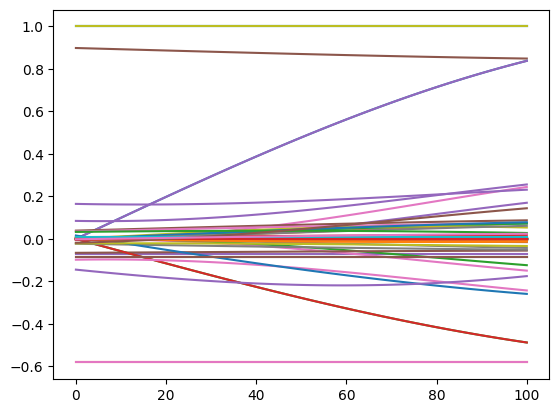

In [438]:
plt.plot(ZEV)
plt.plot(XEV)
plt.plot(YEV)

Because our transpiler permutes the qubits; the order of our features may also be permuted. To verify our 
simulated and transpiled circuits are doing the same thing, we can sort the features:

In [349]:
[tqc1,tMeas1] = Simulated_Transpiled_Reservoir(2,'y')
XEV=[]
YEV=[]
ZEV=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(tqc1,tMeas1,3,2,2,phi2,theta2)
    XEV.append(X0)
    YEV.append(Y0)
    ZEV.append(Z0)
[qc1,Meas1] = Simulated_Reservoir(2,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Features(qc1,3,2,2,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)
print(np.sort(np.array(ZEV),axis=1)[0])
print(np.sort(np.array(ZEVS),axis=1)[0])

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


/tmp/ipykernel_1640017/1737036323.py:126: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  end_mapping={final_perm_lib_qiskit[k].index:k for k in range(20)}
/tmp/ipykernel_1640017/1737036323.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  begin_mapping={init_perm_lib_qiskit[k].index:k for k in range(20)}


[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]
[-7.28281575e-02 -6.54485774e-02 -2.62553109e-16 -2.39622233e-16
 -1.24317332e-16 -5.22178871e-17 -4.75016077e-17 -2.75929453e-17
 -2.38660003e-17 -3.13063377e-18 -2.57498016e-19  7.18283939e-19
  1.55854062e-18  3.78115508e-18  1.11808349e-17  1.15603057e-17
  3.10217347e-17  4.00477177e-17  4.18908614e-17  5.51316805e-17
  8.69394617e-17  1.05235373e-16  1.11767691e-16  1.16538181e-16
  1.24900090e-16  1.25564164e-16  1.35674349e-16  8.98671332e-01
  1.00000000e+00]
[-7.28281575e-02 -6.54485774e-02 -2.11736214e-16 -1.87124825e-16
 -1.79752250e-16 -1.71737624e-16 -1.63597637e-16 -1.10346370e-16
 -1.06443242e-16 -1.05818132e-16 -1.01130652e-16 -9.72275239e-17
 -7.80371454e-17 -6.80048872e-17 -6.31090368e-17 -6.23500952e-17
 -4.79132657e-17 -3.06913918e-17 -2.55041620e-17 -2.01746307e-17
 -1.81146466e-17 -1.67221244e-17  2.49112390e-17  5.55941605e-17
  6.07153217e-17  1.05818132e-16  1.58318928e-16  8.98671332e-01
  1.00000000e+00]


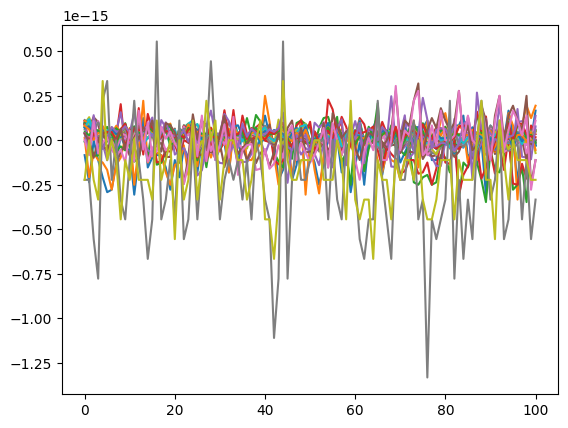

In [441]:
plt.plot(np.sort(np.array(ZEV),axis=1)-np.sort(np.array(ZEVS),axis=1))

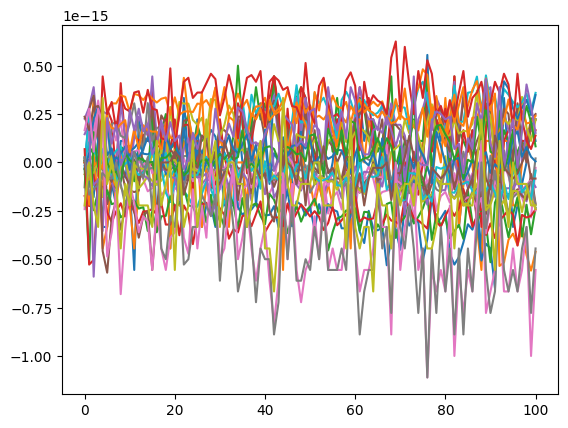

In [442]:
plt.plot(np.sort(np.array(XEV),axis=1)-np.sort(np.array(XEVS),axis=1))

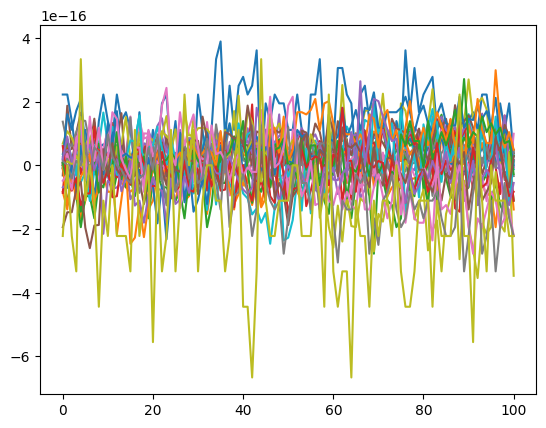

In [443]:
plt.plot(np.sort(np.array(YEV),axis=1)-np.sort(np.array(YEVS),axis=1))

# We also check that optimising the single qubit gates does not change things:

In [444]:
[tqc3pre,tMeas3] = Simulated_Transpiled_Reservoir(2,'y')
tqc3post=optimize_single_qubit_gates(tqc3pre,drop_final_rz=False)
XEV3=[]
YEV3=[]
ZEV3=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(tqc3post,tMeas3,3,2,2,phi2,theta2)
    XEV3.append(X0)
    YEV3.append(Y0)
    ZEV3.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


/tmp/ipykernel_1640017/1737036323.py:126: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  end_mapping={final_perm_lib_qiskit[k].index:k for k in range(20)}
/tmp/ipykernel_1640017/1737036323.py:127: DeprecationWarning: The property ``qiskit.circuit.bit.Bit.index`` is deprecated as of qiskit-terra 0.17. It will be removed no earlier than 3 months after the release date. Instead, use :meth:`~qiskit.circuit.quantumcircuit.QuantumCircuit.find_bit` to find all the containing registers within a circuit and the index of the bit within the circuit.
  begin_mapping={init_perm_lib_qiskit[k].index:k for k in range(20)}


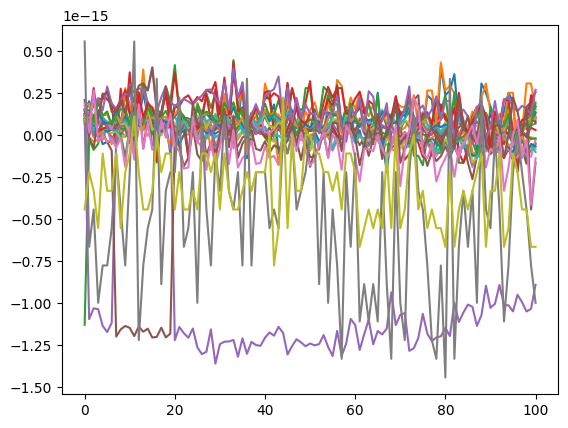

In [445]:
plt.plot(np.sort(np.array(ZEV3),axis=1)-np.sort(np.array(ZEVS),axis=1))

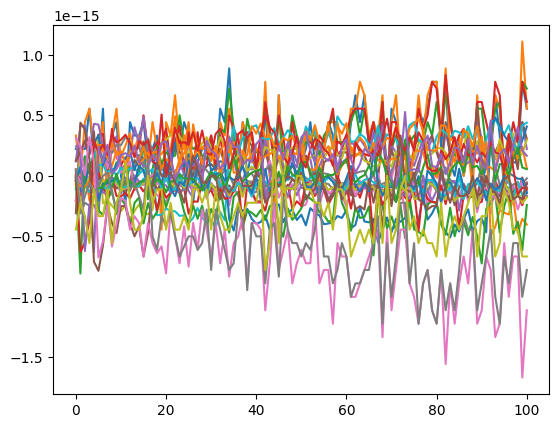

In [446]:
plt.plot(np.sort(np.array(XEV3),axis=1)-np.sort(np.array(XEVS),axis=1))

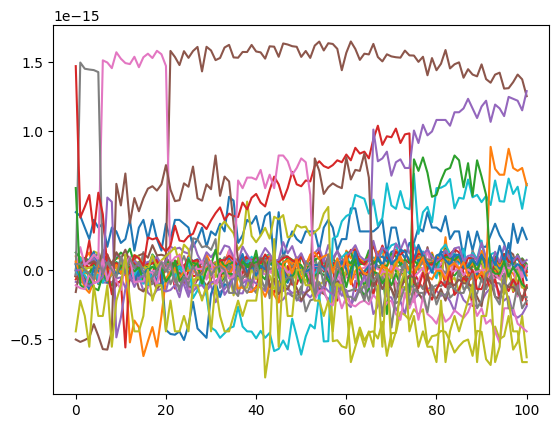

In [447]:
plt.plot(np.sort(np.array(YEV3),axis=1)-np.sort(np.array(YEVS),axis=1))

# Next, we want to check MY "pre-transpiled" version!

In [21]:
def make_manual_circuit(nsteps_in,enc):
    Meas_List=[]
    Manual_Layout_List=[[15,14,9,18,19],
                        [15,14,9,8,13],
                        [15,14,9,11,16],
                        [15,14,9,5,10]]

    
    qc = QuantumCircuit(20,20)
    

        
    
    #Manually create a swap:
    cSWAP=QuantumCircuit(2,0)
    cSWAP.swap(0,1)
    gSWAP=transpile(cSWAP, basis_gates=['r', 'cz'], optimization_level = 0)
    
        
    theta_list=[Parameter('theta_'+str(i)) for i in range(len(Manual_Layout_List[0]))]
    for step in range(nsteps_in): # Loop over all steps used..:
        c_qubits=Manual_Layout_List[step]
        # Add undefined inputs:
        qn = 0 # qubit counter for loop
        for c in range(1):
            for d in range(int(2 / 1)): # dimx
                phi_c = Parameter('phi_'+str(step)+'_'+str(qn))
                #print(step,qn,c_qubits[self.memory_size+0*self.dimxqc+self.qin[qn]])
                if True:
                    match enc :
                        case 'x':
                            qc.r(theta=phi_c,phi=0, qubit=c_qubits[3+[0,1][qn]])
                        case 'y':
                            qc.r(theta=phi_c,phi=np.pi/2, qubit=c_qubits[3+[0,1][qn]])
                        case 'z':
                            qc.r(theta=np.pi/2,phi=0, qubit=c_qubits[3+[0,1][qn]])
                            qc.r(theta=-phi_c,phi=np.pi/2, qubit=c_qubits[3+[0,1][qn]])
                            qc.r(theta=-np.pi/2,phi=0, qubit=c_qubits[3+[0,1][qn]])
                        case _:
                            raise Warning(f'Invalid encaxes={enc}')
                elif self.enctype == 'ryrz': 
                    # self.encaxes = ['ry', 'rz']
                    #qc.h(qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    #qc.ry(np.arctan(phi_c) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])
                    #qc.rz(np.arctan(phi_c**2) + np.pi/4, qubit=self.memory_size+step*self.dimxqc+self.qin[qn])

                    #h
                    qc.r(theta=np.pi/2,phi=np.pi/2, qubit=self.memory_size+self.qin[qn])
                    qc.r(theta=np.pi,phi=0, qubit=self.memory_size+self.qin[qn])
                    #y
                    qc.r(theta=np.arctan(phi_c) + np.pi/4,phi=np.pi/2, qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    #z
                    qc.r(theta=np.pi/2,phi=0, qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.r(theta=np.arctan(phi_c**2) + np.pi/4,phi=np.pi/2, qubit=self.memory_size+0*self.dimxqc+self.qin[qn])
                    qc.r(theta=-np.pi/2,phi=0, qubit=self.memory_size+0*self.dimxqc+self.qin[qn])

                else:
                    raise Warning(f'Invalid enctype {self.enctype}')
                qn += 1
            
                

            
        for i in range(len(c_qubits)):
            #H
            qc.r(theta=np.pi/2,phi=np.pi/2, qubit=c_qubits[i])
            qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])



        # CZ
        qc.cz(c_qubits[0],c_qubits[1])
            
        if step==0:
        #SWAP CZ
            qc=qc.compose(gSWAP,qubits=[c_qubits[1],c_qubits[2]])
            qc.cz(c_qubits[1],c_qubits[3])
            qc=qc.compose(gSWAP,qubits=[c_qubits[1],c_qubits[2]])
        elif step==1:
            qc.cz(c_qubits[2],c_qubits[3])
        elif step==2:
            qc=qc.compose(gSWAP,qubits=[c_qubits[2],10]) # use auxillary.
            qc.cz(10,c_qubits[3]) 
            qc=qc.compose(gSWAP,qubits=[c_qubits[2],10])
            
        elif step==3:
            qc=qc.compose(gSWAP,qubits=[c_qubits[2],c_qubits[4]]) # use auxillary.
            qc.cz(c_qubits[4],c_qubits[3]) 
            qc=qc.compose(gSWAP,qubits=[c_qubits[2],c_qubits[4]])

        else:
            print('Error! Too many steps')

        qc.cz(c_qubits[1],c_qubits[2])
        qc.cz(c_qubits[3],c_qubits[4])

        #Final CZ
        if step==0:
        #SWAP CZ
            qc.cz(c_qubits[0],c_qubits[4])
        elif step==1:
            qc=qc.compose(gSWAP,qubits=[c_qubits[1],c_qubits[4]]) # use auxillary.
            qc.cz(c_qubits[0],c_qubits[1])
            qc=qc.compose(gSWAP,qubits=[c_qubits[1],c_qubits[4]])
        elif step==2:
            qc.cz(c_qubits[0],c_qubits[4])
            
        elif step==3:
            qc.cz(c_qubits[0],c_qubits[4])
        else:
            print('Error! Too many steps')

        #XROT
        for i in range(len(c_qubits)):
            #X
            qc.r(theta=theta_list[i],phi=0, qubit=c_qubits[i])
            #H
            qc.r(theta=np.pi/2,phi=np.pi/2, qubit=c_qubits[i])
            qc.r(theta=np.pi,phi=0, qubit=c_qubits[i])

            

            



    
        #We will keep track of which measurements to perform here:
        if 2 > 0:
            adj_meas=[k + 3 for k in [0,1]]
            
            Meas_List  += [[Manual_Layout_List[step][k] for k in adj_meas]]

    #In the last step, we measure ALL qubits.
    Meas_List[nsteps_in-1]=Manual_Layout_List[nsteps_in-1]
    return qc, Meas_List

In [449]:
[mqc1,mMeas1] = make_manual_circuit(1,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,1,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)
[qc1,Meas1] = Simulated_Reservoir(1,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Features(qc1,3,2,1,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)
print(np.sort(np.array(ZEV),axis=1)[0])
print(np.sort(np.array(ZEVS),axis=1)[0])

[[0, 1, 2, 3, 4]]
[-7.28281575e-02 -6.54485774e-02 -2.19334099e-16 -7.78118347e-17
 -7.63278329e-17 -7.20994445e-17 -6.72205347e-17 -5.00901404e-17
 -1.43317975e-17 -9.71716197e-18  1.21430643e-17  1.30917412e-17
  1.81061763e-17  2.24565375e-17  2.28766658e-17  2.69966341e-17
  2.84264257e-17  4.33680869e-17  5.01985606e-17  5.25092665e-17
  5.25770291e-17  6.59194921e-17  7.11236625e-17  9.49761103e-17
  9.99736047e-17  1.42355745e-16  1.58835618e-16  8.98671332e-01
  1.00000000e+00]
[-1.90819582e-16 -1.24900090e-16 -1.11022302e-16 -1.00613962e-16
 -9.71445147e-17 -7.28583860e-17 -6.93889390e-17 -4.16333634e-17
 -2.77555756e-17 -1.38777878e-17 -1.38777878e-17  0.00000000e+00
  1.73472348e-18  1.73472348e-17  2.60208521e-17  2.60208521e-17
  2.94902991e-17  4.16333634e-17  5.55111512e-17  7.11236625e-17
  1.09287579e-16  1.24900090e-16  1.37043155e-16  1.66533454e-16
  1.82145965e-16]


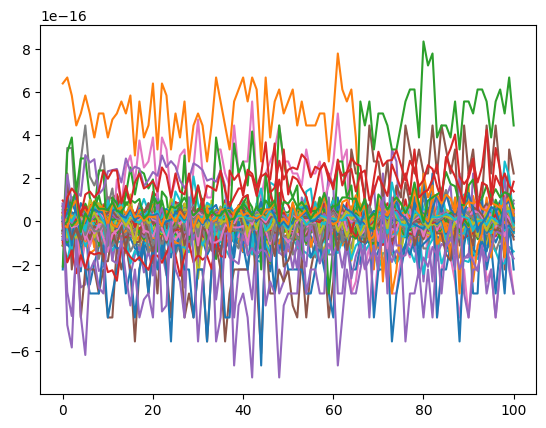

In [451]:
plt.plot(np.sort(np.array(ZEV4),axis=1)-np.sort(np.array(ZEVS),axis=1))
plt.plot(np.sort(np.array(YEV4),axis=1)-np.sort(np.array(YEVS),axis=1))
plt.plot(np.sort(np.array(XEV4),axis=1)-np.sort(np.array(XEVS),axis=1))

In [452]:
[mqc1,mMeas1] = make_manual_circuit(2,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,2,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)
[qc1,Meas1] = Simulated_Reservoir(2,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Features(qc1,3,2,2,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)


[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6]]


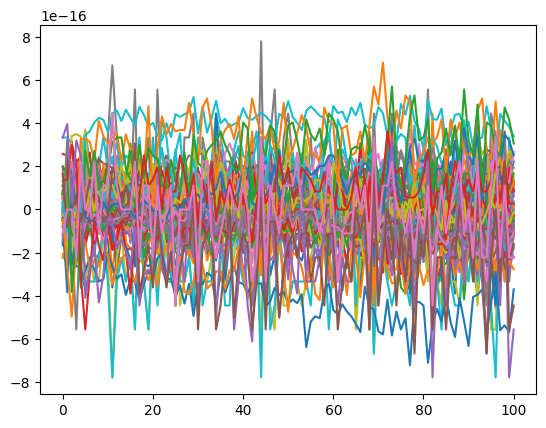

In [453]:
plt.plot(np.sort(np.array(ZEV4),axis=1)-np.sort(np.array(ZEVS),axis=1))
plt.plot(np.sort(np.array(YEV4),axis=1)-np.sort(np.array(YEVS),axis=1))
plt.plot(np.sort(np.array(XEV4),axis=1)-np.sort(np.array(XEVS),axis=1))

In [454]:
[mqc1,mMeas1] = make_manual_circuit(3,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,3,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)
[qc1,Meas1] = Simulated_Reservoir(3,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Features(qc1,3,2,3,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)


[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6], [0, 1, 2, 7, 8]]


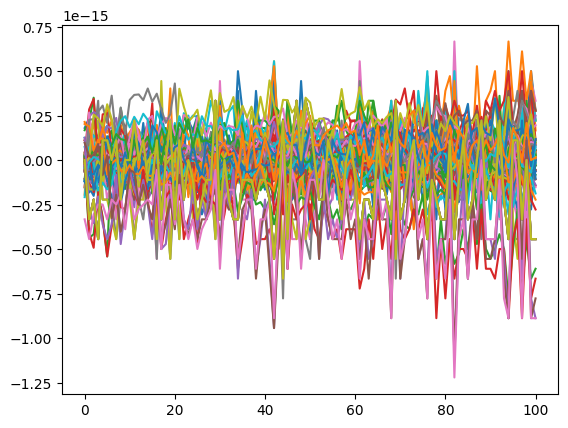

In [455]:
plt.plot(np.sort(np.array(ZEV4),axis=1)-np.sort(np.array(ZEVS),axis=1))
plt.plot(np.sort(np.array(YEV4),axis=1)-np.sort(np.array(YEVS),axis=1))
plt.plot(np.sort(np.array(XEV4),axis=1)-np.sort(np.array(XEVS),axis=1))

In [456]:
[mqc1,mMeas1] = make_manual_circuit(4,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,4,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)
[qc1,Meas1] = Simulated_Reservoir(4,'y')
XEVS=[]
YEVS=[]
ZEVS=[]
for i in np.linspace(0,1,101):
    phi2=np.array([[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i],[np.pi*0.8,i]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Features(qc1,3,2,4,phi2,theta2)
    XEVS.append(X0)
    YEVS.append(Y0)
    ZEVS.append(Z0)

[[0, 1, 2, 3, 4], [0, 1, 2, 5, 6], [0, 1, 2, 7, 8], [0, 1, 2, 9, 10]]


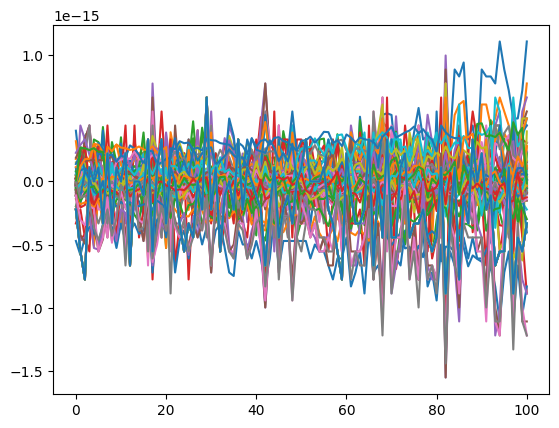

In [457]:
plt.plot(np.sort(np.array(ZEV4),axis=1)-np.sort(np.array(ZEVS),axis=1))
plt.plot(np.sort(np.array(YEV4),axis=1)-np.sort(np.array(YEVS),axis=1))
plt.plot(np.sort(np.array(XEV4),axis=1)-np.sort(np.array(XEVS),axis=1))

In [24]:
examplex=np.array([[0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.8       ],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667],
       [0.62666667]]).squeeze()

In [23]:
exampley=np.array([[0.15343628],
       [0.20890747],
       [0.26797933],
       [0.32962931],
       [0.37909871],
       [0.44027547],
       [0.50161662],
       [0.56135539],
       [0.61871908],
       [0.67121175],
       [0.72014364],
       [0.77518799],
       [0.81695068],
       [0.85264486],
       [0.8827299 ],
       [0.90717651],
       [0.92890015],
       [0.94232463],
       [0.95102376],
       [0.95645386],
       [0.95789632],
       [0.95690999],
       [0.9542985 ],
       [0.95053304],
       [0.94485067],
       [0.9383016 ],
       [0.93160685],
       [0.92428792],
       [0.91737427],
       [0.90968628],
       [0.90270223],
       [0.89566772],
       [0.88257487],
       [0.86082601],
       [0.83724487],
       [0.81413371],
       [0.79370524],
       [0.77623901],
       [0.75951375],
       [0.74803141],
       [0.73867187],
       [0.73130208],
       [0.72603719],
       [0.72051717],
       [0.7174231 ],
       [0.71511149],
       [0.71450968],
       [0.71448975],
       [0.71520955],
       [0.71645142],
       [0.71870199],
       [0.72119425],
       [0.71629272],
       [0.70705648],
       [0.69408854]]).squeeze()

In [27]:
[mqc1,mMeas1] = make_manual_circuit(4,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in range(3,len(examplex)):
    phi2=np.array([[np.pi*examplex[i-3],np.pi*exampley[i-3]],[np.pi*examplex[i-2],np.pi*exampley[i-2]],[np.pi*examplex[i-1],np.pi*exampley[i-1]],[np.pi*examplex[i],np.pi*exampley[i]]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,4,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)

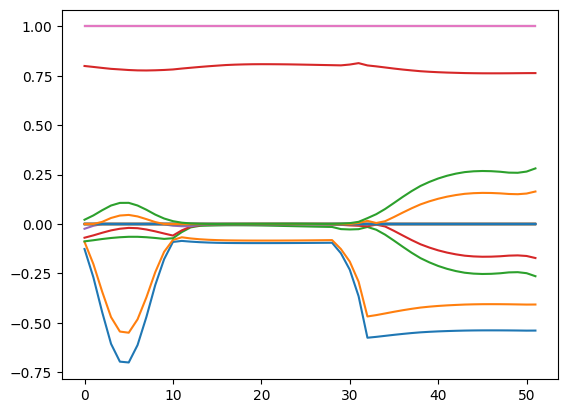

In [30]:
plt.plot(np.sort(np.array(ZEV4),axis=1))
#plt.plot(np.sort(np.array(XEV4),axis=1))
#plt.plot(np.sort(np.array(YEV4),axis=1))

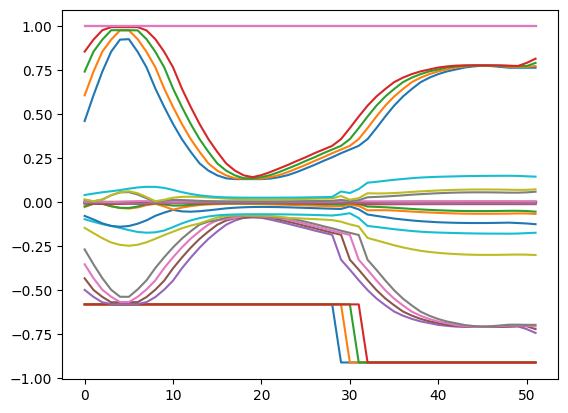

In [31]:
plt.plot(np.sort(np.array(XEV4),axis=1))

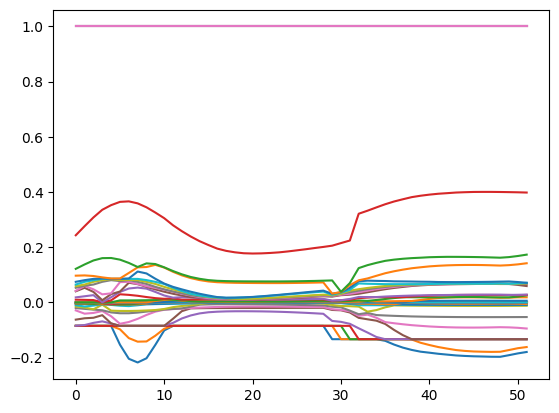

In [32]:
plt.plot(np.sort(np.array(YEV4),axis=1))

In [33]:
[mqc1,mMeas1] = make_manual_circuit(4,'y')
XEV4=[]
YEV4=[]
ZEV4=[]
for i in range(3,len(examplex)):
    phi2=np.array([[np.arccos(examplex[i-3]),np.arccos(exampley[i-3])],[np.arccos(examplex[i-2]),np.arccos(exampley[i-2])],[np.arccos(examplex[i-1]),np.arccos(exampley[i-1])],[np.arccos(examplex[i]),np.arccos(exampley[i])]])
    theta2=np.array([2.84,-4.5,9.08,9.57,6.37])
    X0,Y0,Z0,ev,sv =Evaluate_Transpiled_Features(mqc1,mMeas1,3,2,4,phi2,theta2)
    XEV4.append(X0)
    YEV4.append(Y0)
    ZEV4.append(Z0)

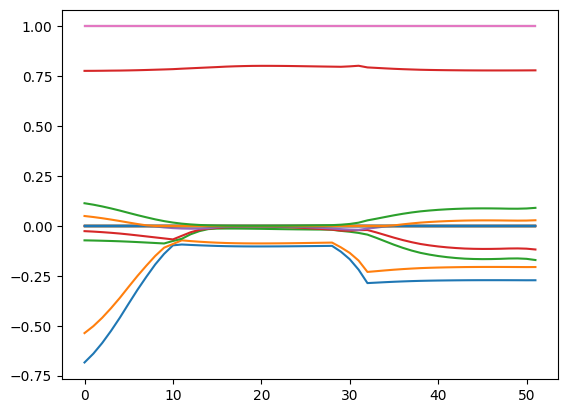

In [34]:
plt.plot(np.sort(np.array(ZEV4),axis=1))

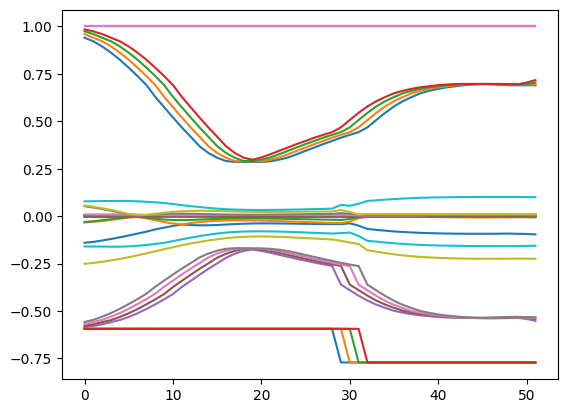

In [35]:
plt.plot(np.sort(np.array(XEV4),axis=1))

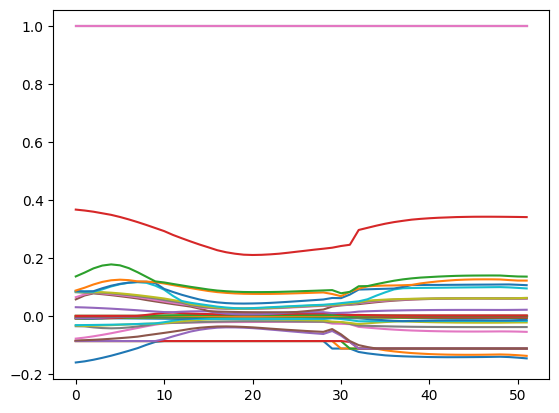

In [36]:
plt.plot(np.sort(np.array(YEV4),axis=1))